In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
from typing import Dictfrom scipy.signal import savgol_filter
from xarray import Dataset
from pathlib import Path
import xarray as xr
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt

In [2]:
plt.rc("font", family="STIXGeneral", size=9)
plt.rc("figure", dpi=300)
plt.rc("savefig", dpi=300, bbox="tight", pad_inches=0.1, transparent=True, format="pdf")
plt.rc("figure", figsize=(5.3, 2.4))
plt.rc("mathtext", fontset="stix")


def savefig(name: str, raw_fmt: str = "eps"):
    !mkdir -p ../reports/figures/publi/raw
    !mkdir -p ../reports/figures/publi/pdf
    plt.savefig(f"../reports/figures/publi/pdf/{name}.pdf", dpi=300, bbox_inches="tight")
    plt.savefig(f"../reports/figures/publi/raw/{name}.{raw_fmt}", dpi=600, bbox_inches="tight")


def compute_spread_len(ds, h_factor=1.05):
    mask = ds.h > (ds.attrs["hₛ"] * h_factor)
    dx = ds.x[1] - ds.x[0]
    return mask.sum("x") * dx


def compute_drop_velocity(ds):
    hmax_pos = ds.x[ds.h.argmax("x")]
    ptp = ds.x.max() - ds.x.min()
    area = (hmax_pos.diff("t") < -ptp / 2).cumsum().rename("area")
    largest_area = area.to_dataframe().area.value_counts().index[0]
    hmax_pos = hmax_pos.where(area == largest_area, drop=True)
    c = float(hmax_pos.polyfit("t", deg=1).polyfit_coefficients.sel(degree=1).squeeze())
    return c


datasets: Dict[str, Dataset] = {}
for ds in sorted(Path("../data/outputs/hs_effect_wreproj/").glob("*.nc")):
    ds = xr.open_dataset(ds).isel(y=0)
    ds["spread_len"] = compute_spread_len(ds)
    ds.attrs["drop_velocity"] = compute_drop_velocity(ds.isel(t=slice(-500, None)))
    datasets[ds.attrs["hₛ"]] = ds

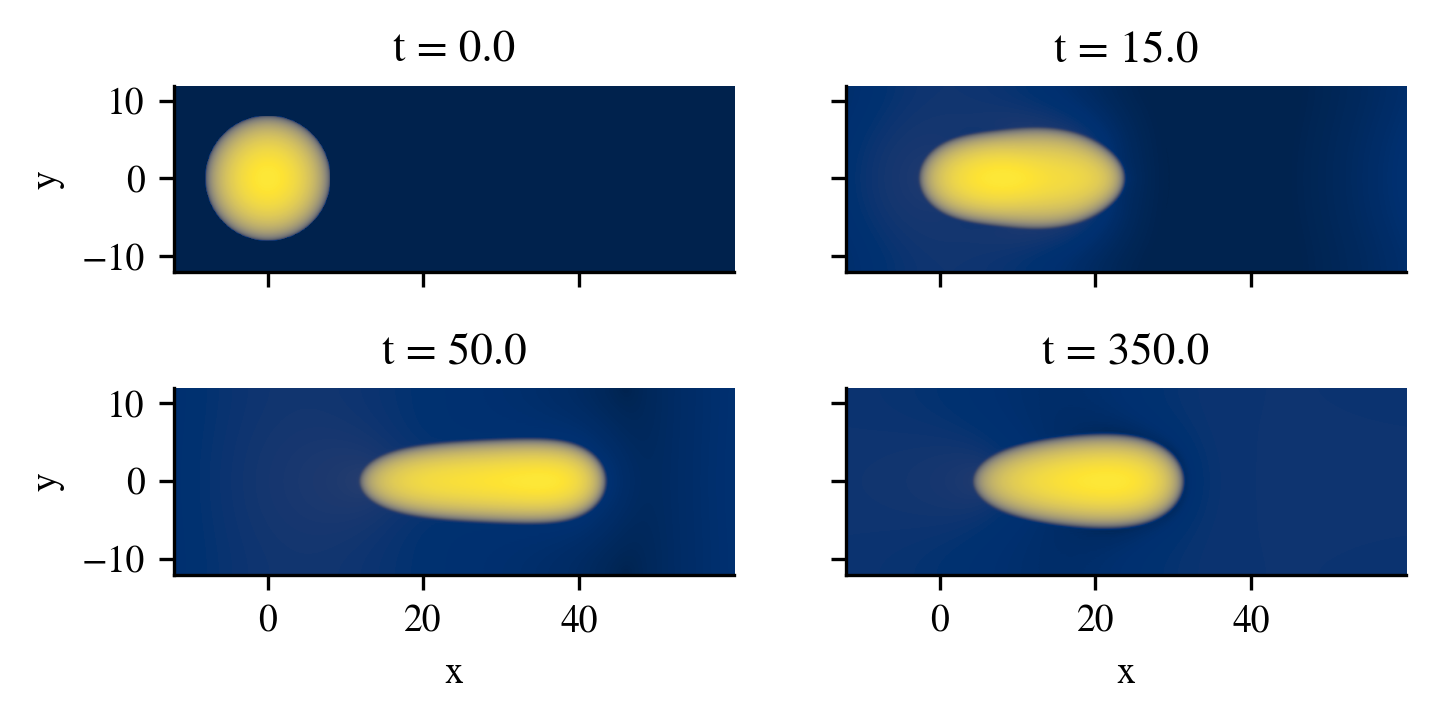

In [3]:
ds = xr.open_dataset("../data/outputs/2D_simple/dθₛ=0.nc")

fig, axs = plt.subplots(2, 2, figsize=(5.3, 2.4), sharex=True, sharey=True)
for ax, t in zip(axs.flat, [0, 15, 50, 350]):
    ds.h.sel(t=t).plot.imshow(
        cmap="cividis",
        interpolation="antialiased",
        add_colorbar=False,
        norm=plt.matplotlib.colors.PowerNorm(0.3),
        ax=ax,
    )
    ax.set_aspect("equal")
    sns.despine()
[ax.set_xlabel("") for ax in axs[0, :]]
[ax.set_ylabel("") for ax in axs[:, -1]]
savefig("fig06")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


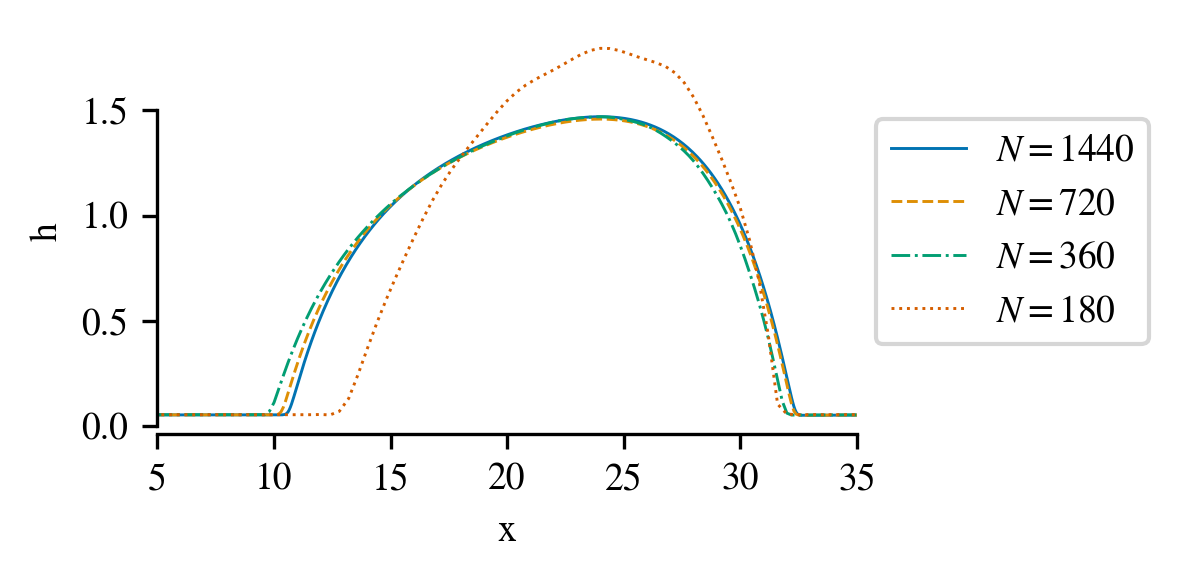

In [4]:
# fig 03
from matplotlib.rcsetup import cycler

fig, ax = plt.subplots(figsize=(4, 2))
sns.set_palette("colorblind")
ls_cycle = cycler(linestyle=["-", "--", "-.", ":"])
color_cycler = cycler(color=sns.color_palette("colorblind", n_colors=len(ls_cycle)))
ax.set_prop_cycle(ls_cycle + color_cycler)
for file in sorted(
    Path("../data/outputs/converge_N_1D/").glob("*.nc"),
    reverse=True,
    key=lambda x: float(x.stem.split("=")[1]),
):
    da = xr.open_dataset(file).h.isel(t=-1).sel(y=0)
    da = da.roll(x=len(da.x) // 2 - int(da.argmax("x")), roll_coords=False)
    da.plot(linewidth=0.7, label=rf"$N={len(da.x)}$")
ax.set_title("")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

ax.set_xlim(5, 35)
sns.despine(trim=True)
fig.tight_layout()
savefig("fig02")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


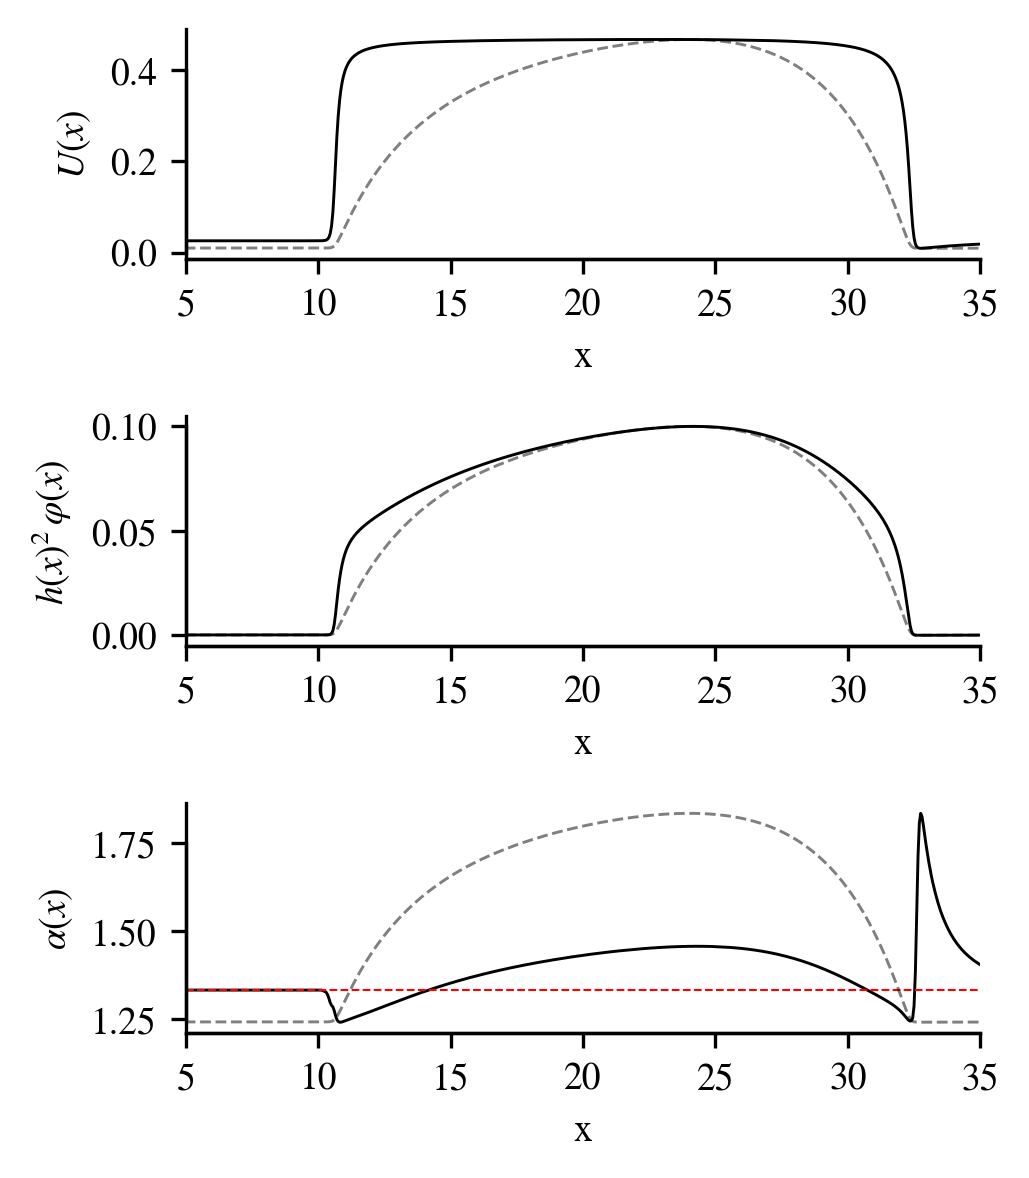

In [5]:
from matplotlib.rcsetup import cycler
from pyparsing import line

fig, (ax_u, ax_phi, ax_alpha) = plt.subplots(3, figsize=(3.5, 4))
sns.set_palette("colorblind")
ls_cycle = cycler(linestyle=["-", "--", "-.", ":"])
color_cycler = cycler(color=sns.color_palette("colorblind", n_colors=len(ls_cycle)))
ax.set_prop_cycle(ls_cycle + color_cycler)

file = Path("../data/outputs/converge_N_1D/hₛ_ratio=2.0.nc")
ds = xr.open_dataset(file).isel(t=-1).sel(y=0)
ds = ds.roll(x=len(ds.h.x) // 2 - int(ds.h.argmax("x")), roll_coords=False)

ds.ux.plot(linewidth=0.7, label=rf"$N={len(ds.x)}$", ax=ax_u, color="k")
ax_u_twin = ax_u.twinx()
ds["h"].plot(linewidth=0.7, ax=ax_u_twin, color="k", linestyle="--", alpha=0.5)
ax_u_twin.set_yticks([])
ax_u_twin.set_ylabel("")
ax_u_twin.set_title("")

ax_u.set_title("")
ax_u.set_ylabel(r"$U(x)$")
ax_u.set_xlim(5, 35)


(ds["h"] ** 2 * ds["ϕxx"]).plot(
    linewidth=0.7, label=rf"$N={len(ds.x)}$", ax=ax_phi, color="k"
)
ax_phi_twin = ax_phi.twinx()
ds["h"].plot(linewidth=0.7, ax=ax_phi_twin, color="k", linestyle="--", alpha=0.5)
ax_phi_twin.set_yticks([])
ax_phi_twin.set_ylabel("")
ax_phi_twin.set_title("")
ax_phi.set_ylabel(r"$h(x)^2\,\varphi(x)$")
ax_phi.set_title("")
ax_phi.set_xlim(5, 35)

form_factor = 1.0 + ds.h**2 * ds["ϕxx"] / ds.ux**2

form_factor.plot(linewidth=0.7, label=rf"$N={len(ds.x)}$", ax=ax_alpha, color="k")
ax_alpha.axhline(4 / 3, color="r", linestyle="--", linewidth=0.5)
ax_alpha_twin = ax_alpha.twinx()
ds["h"].plot(linewidth=0.7, ax=ax_alpha_twin, color="k", linestyle="--", alpha=0.5)
ax_alpha_twin.set_yticks([])
ax_alpha_twin.set_ylabel("")
ax_alpha_twin.set_title("")
ax_alpha.set_ylabel(r"$\alpha(x)$")
ax_alpha.set_title("")
ax_alpha.set_xlim(5, 35)

sns.despine(trim=True)
fig.tight_layout()
savefig("fig03")

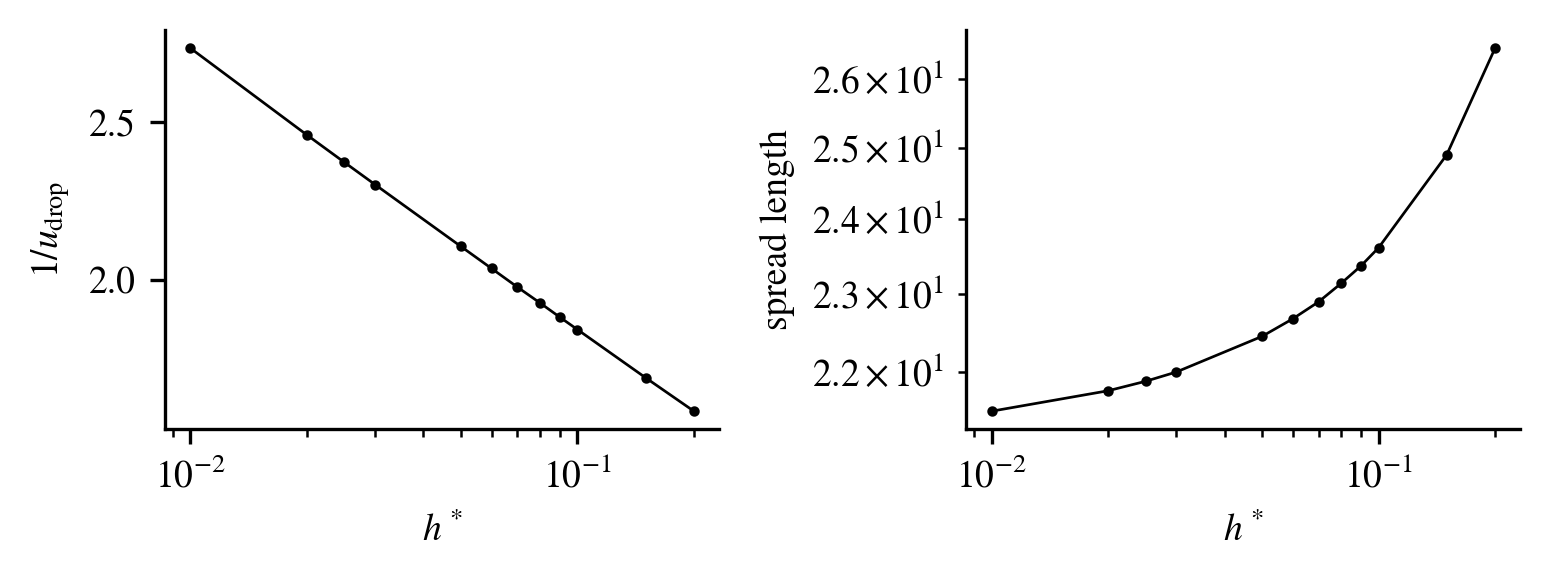

In [6]:
fig, (ax_vel, ax_spread) = plt.subplots(1, 2, figsize=(5.3, 2), sharex=True)
with plt.rc_context(
    {
        "font.family": "sans-serif",
        "text.latex.preamble": r"\usepackage{amsmath}",
    }
):
    ax_vel.plot(
        *zip(*[(hs, 1 / ds.attrs["drop_velocity"]) for hs, ds in datasets.items()]),
        marker=".",
        color="k",
        linewidth=0.65,
        markersize=3,
    )

    ax_vel.set_xscale("log")
    ax_vel.set_xlabel("$h^*$")
    ax_vel.set_ylabel(r"$1 / u_{\rm{drop}}$")
    ax_vel.set_title("")

    sns.despine(ax=ax_vel)

    ax_spread.plot(
        *zip(
            *[
                (hs, ds.spread_len.isel(t=slice(-800, None)).mean())
                for hs, ds in datasets.items()
            ]
        ),
        marker=".",
        color="k",
        linewidth=0.65,
        markersize=3,
    )

    ax_spread.set_xscale("log")
    ax_spread.set_yscale("log")
    ax_spread.set_xlabel("$h^*$")
    ax_spread.set_ylabel("spread length")
    ax_spread.set_title("")

    sns.despine(ax=ax_spread)
    fig.tight_layout()
    savefig("fig05")

/tmp/ipykernel_164722/1605328373.py:31: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


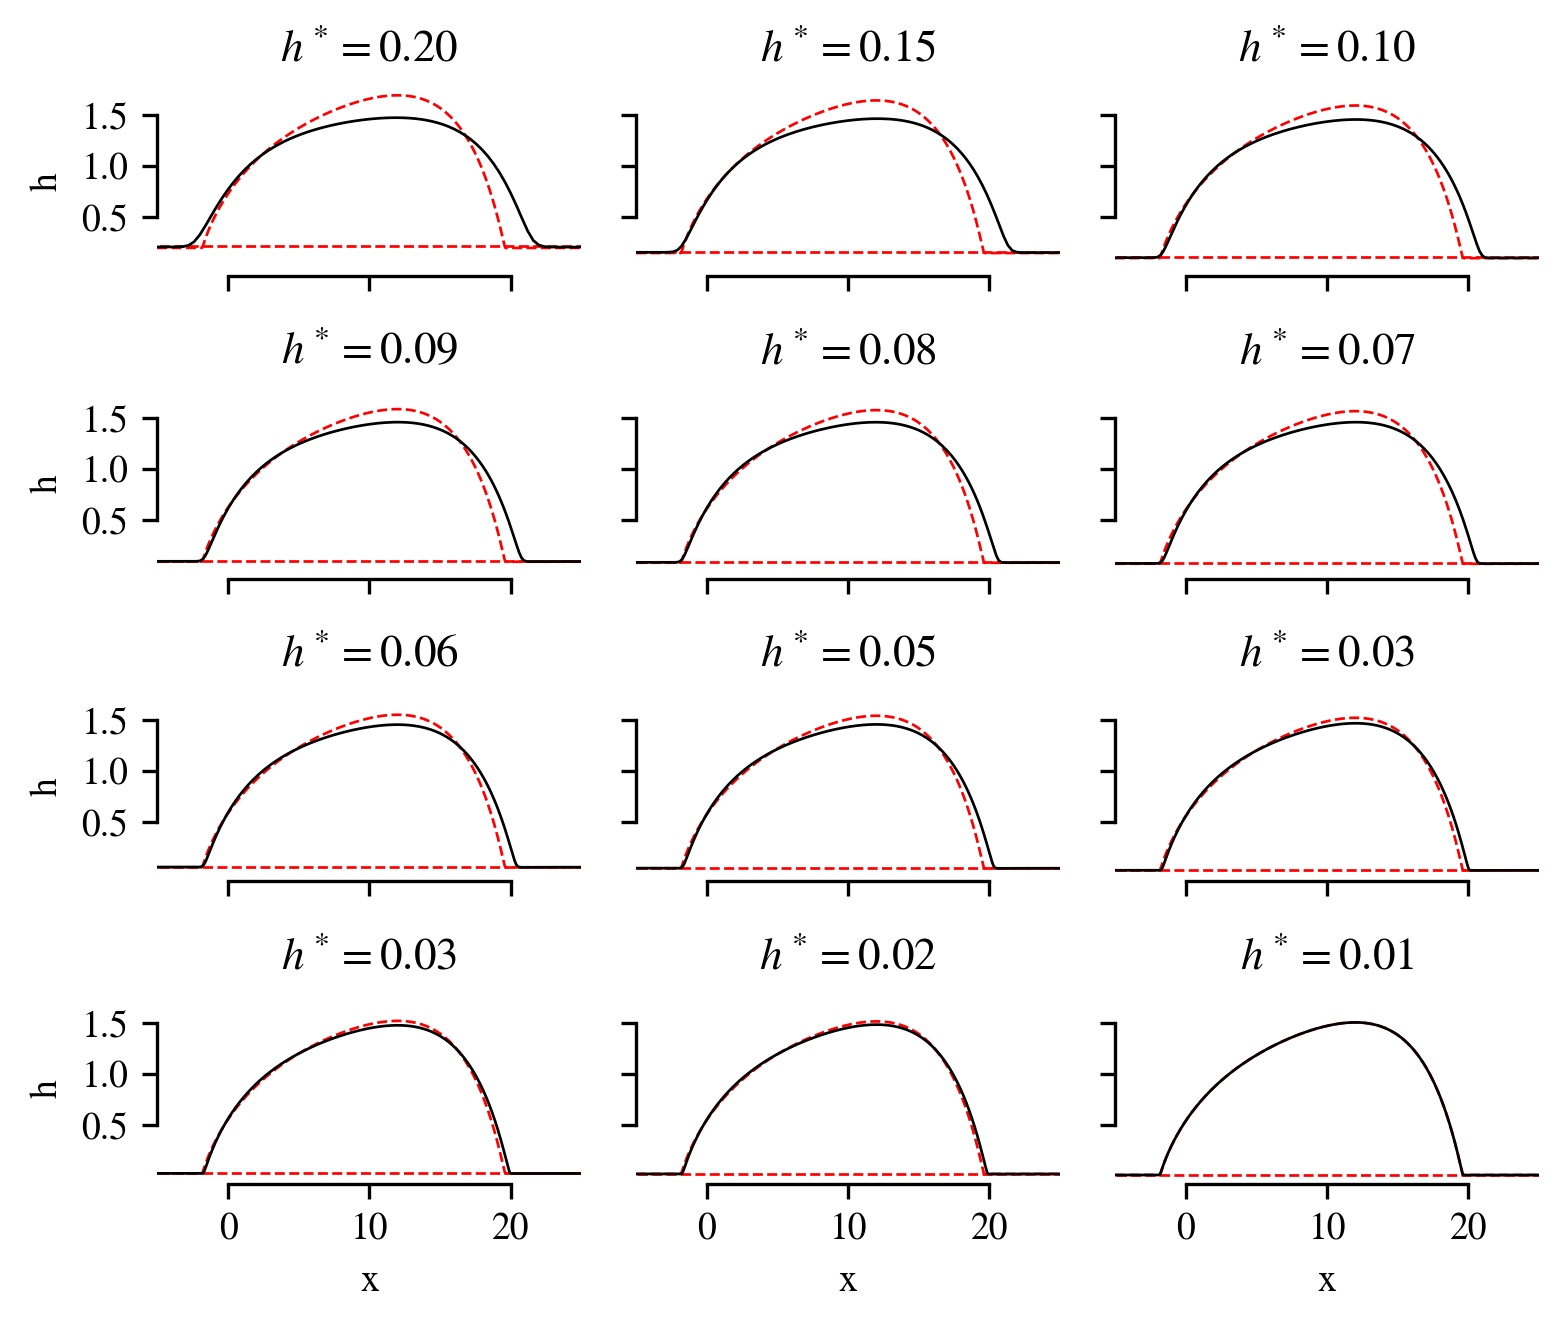

In [7]:
fig, axs = plt.subplots(
    4, 3, figsize=(5.3, 4.5), sharex=True, sharey=True, constrained_layout=True
)
ref = datasets[0.01].h.isel(t=-1)
ref = ref.roll(x=len(ref.x) // 2 - int(ref.argmax("x"))) - 0.01

for hs, ax in zip(reversed(datasets.keys()), axs.flatten()):
    ds = datasets[hs]
    xmin, xmax = ds.x.min(), ds.x.max()
    # n_traces = 10
    # step = len(ds.t) // n_traces
    # for i, t in enumerate(ds.t[::step]):
    #     if i == 0:
    #         continue
    #     frame = ds.h.sel(t=t)
    #     frame = frame.roll(x=len(ds.x) // 2 - int(frame.argmax("x")))
    #     frame.plot(ax=ax, color="k", alpha=(i / n_traces) * (0.8 - 0.1) + 0.1, linewidth=0.65)
    frame = ds.h.isel(t=-1)
    frame = frame.roll(x=len(ds.x) // 2 - int(frame.argmax("x")))
    ax.hlines(
        ds.attrs["hₛ"] * 1.1, xmin, xmax, color="r", linestyle="--", linewidth=0.65
    )
    (ref + hs).plot(ax=ax, color="red", linewidth=0.65, linestyle="--")
    frame.plot(ax=ax, color="k", linewidth=0.65)
    ax.set_title(rf"$h^* = {ds.attrs['hₛ']:.2f}$")
    ax.set_xlim(-5, 25)
    sns.despine(trim=True)
[ax.set_xlabel("") for ax in axs[:-1, :].flat]
[ax.set_ylabel("") for ax in axs[:, 1:].flat]

fig.tight_layout()
savefig("fig04")

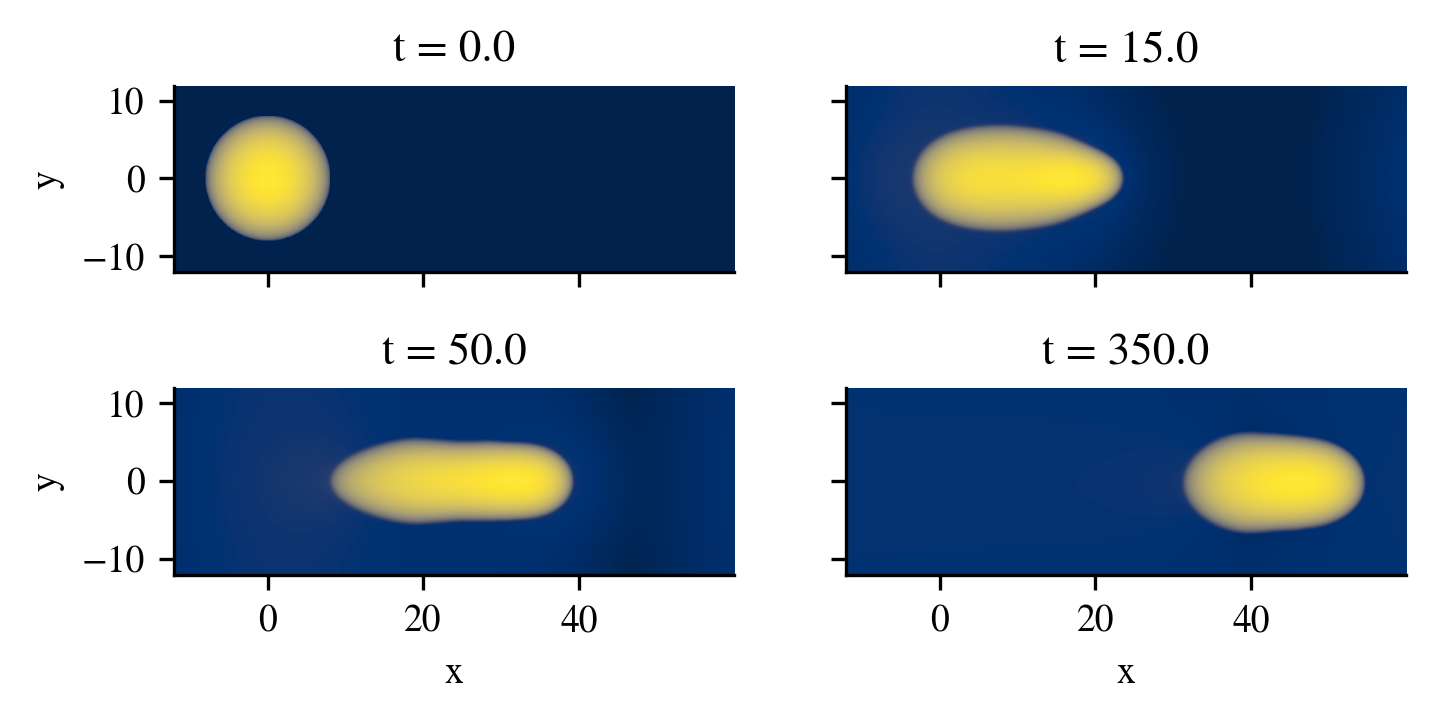

In [8]:
# fig 04
ds = xr.open_dataset("../data/outputs/2D_simple/dθₛ=5.nc")
# use serif
fig, axs = plt.subplots(2, 2, figsize=(5.3, 2.4), sharex=True, sharey=True)
for ax, t in zip(axs.flat, [0, 15, 50, 350]):
    ds.h.sel(t=t).plot.imshow(
        cmap="cividis",
        interpolation="antialiased",
        add_colorbar=False,
        norm=plt.matplotlib.colors.PowerNorm(0.3),
        ax=ax,
    )
    ax.set_aspect("equal")
    sns.despine()
[ax.set_xlabel("") for ax in axs[0, :]]
[ax.set_ylabel("") for ax in axs[:, -1]]
savefig("fig08")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


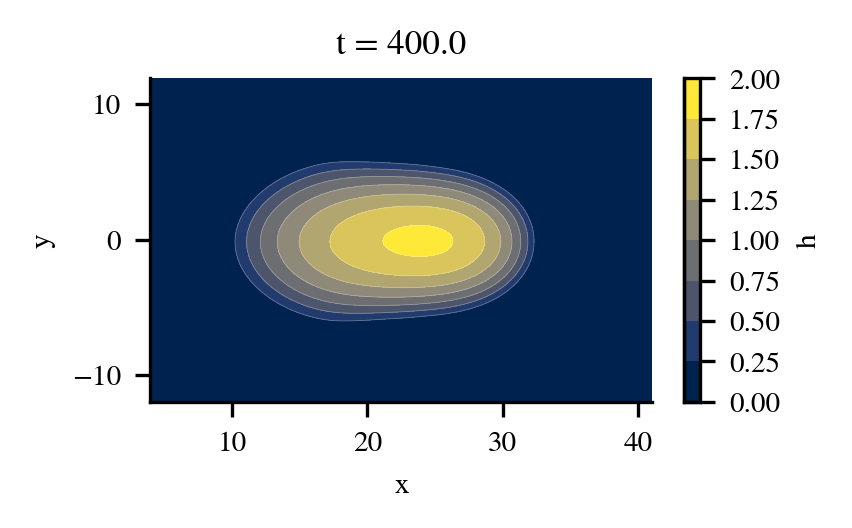

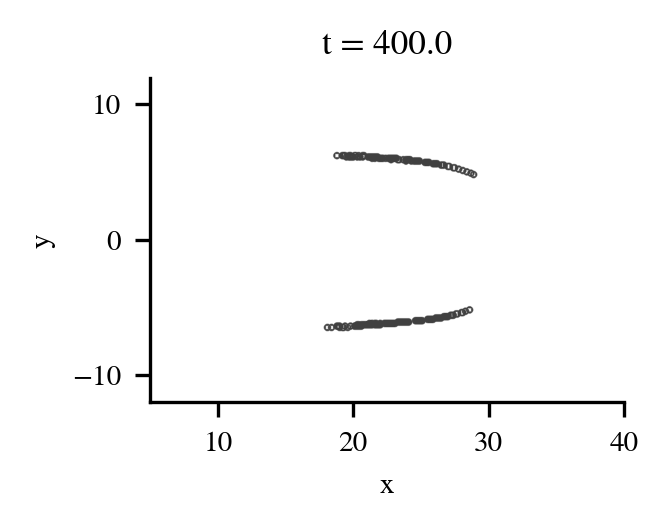

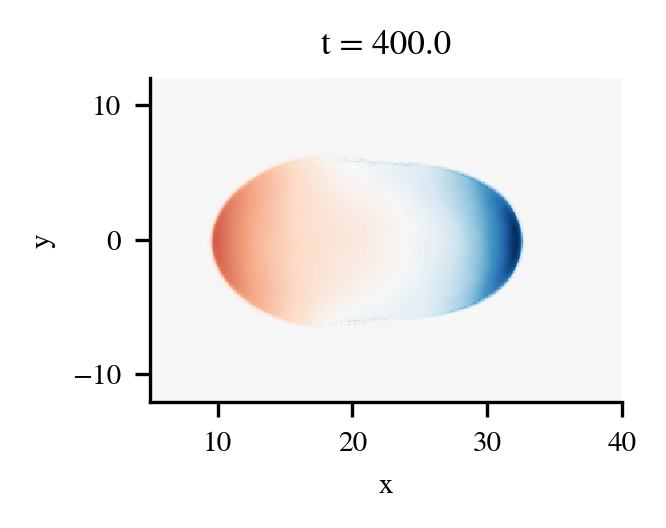

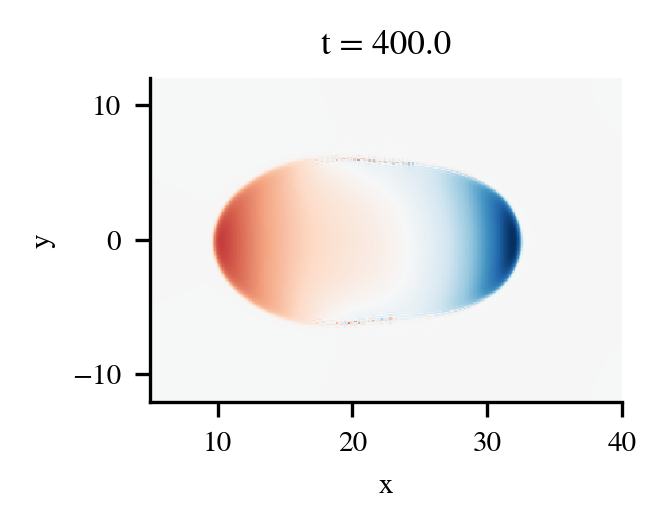

In [19]:
# fig 05

ds = xr.open_dataset("../data/outputs/2D_simple/dθₛ=5.nc")
ds = ds.sel(t=400)
ds = ds.roll(x=len(ds.x) // 2 - int(ds.sel(y=0).h.argmax("x")), roll_coords=False)
# (a)
with plt.rc_context({"font.size": 7}):
    fig, ax = plt.subplots(figsize=(2.7, 1.4))
    ax.set_aspect("equal", "datalim")
    ds.h.plot.contourf(
        levels=np.arange(0, 2.1, 0.25), cmap="cividis", add_colorbar=True, ax=ax
    )
    ds.h.plot.contour(
        levels=np.arange(0, 2.1, 0.25), colors="white", linewidths=0.2, alpha=0.3, ax=ax
    )
    ax.set_xlim(5, 40)
    sns.despine()
    savefig("fig09a")
# (b)
with plt.rc_context({"font.size": 7}):
    fig, ax = plt.subplots(figsize=(2.7, 1.4))
    ax.set_aspect("equal", "box")

    dx_hux = (ds.h * ds.ux).differentiate("x")
    dy_huy = (ds.h * ds.uy).differentiate("y")
    div_hU = dx_hux + dy_huy

    flag = (
        (1.2 * ds.attrs["hₛ"] < ds.h)
        & (ds.h < 2 * ds.attrs["hₛ"])
        & (np.abs(div_hU) < 1e-3)
    )
    flag.plot.contour(ax=ax, cmap="Greys", add_colorbar=False)

    ax.set_xlim(5, 40)
    sns.despine()
    savefig("fig09b")
# (c)
with plt.rc_context({"font.size": 7}):
    fig, ax = plt.subplots(figsize=(2.7, 1.4))
    ax.set_aspect("equal", "box")

    dx_hux = (ds.h * ds.ux).differentiate("x")
    dy_huy = (ds.h * ds.uy).differentiate("y")
    div_hU = dx_hux + dy_huy
    div_hU.plot.pcolormesh(add_colorbar=False, ax=ax, rasterized=True)
    ax.set_xlim(5, 40)
    sns.despine()
    savefig("fig09c")
# (d)
with plt.rc_context({"font.size": 7}):
    fig, ax = plt.subplots(figsize=(2.7, 1.4))
    ax.set_aspect("equal", "box")

    dx_h = ds.h.differentiate("x")
    dy_h = ds.h.differentiate("y")

    U_gradh = ds.ux * dx_h + ds.uy * dy_h
    U_gradh.plot.pcolormesh(add_colorbar=False, ax=ax, rasterized=True)
    ax.set_xlim(5, 40)
    sns.despine()
    savefig("fig09d")

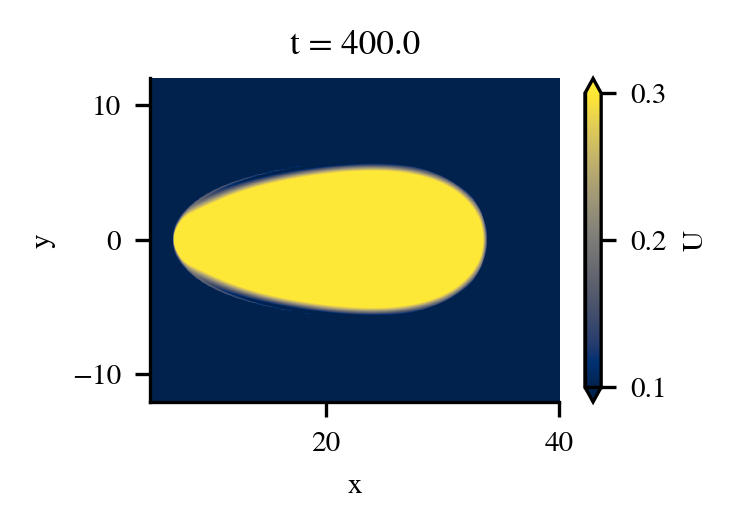

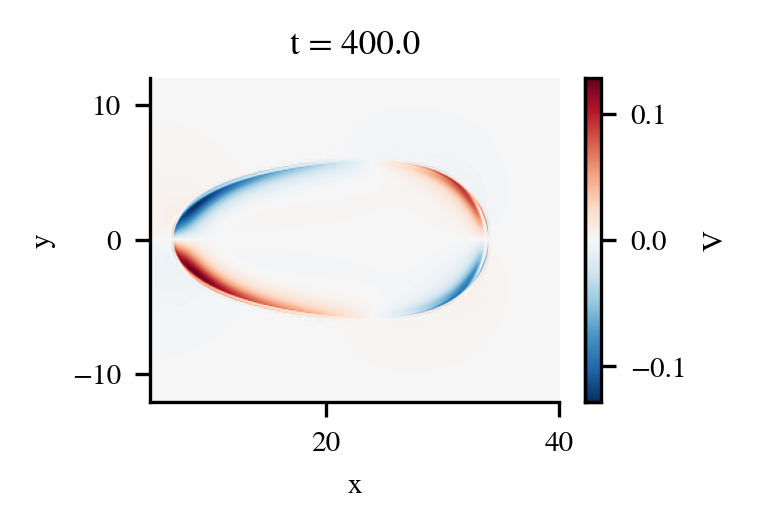

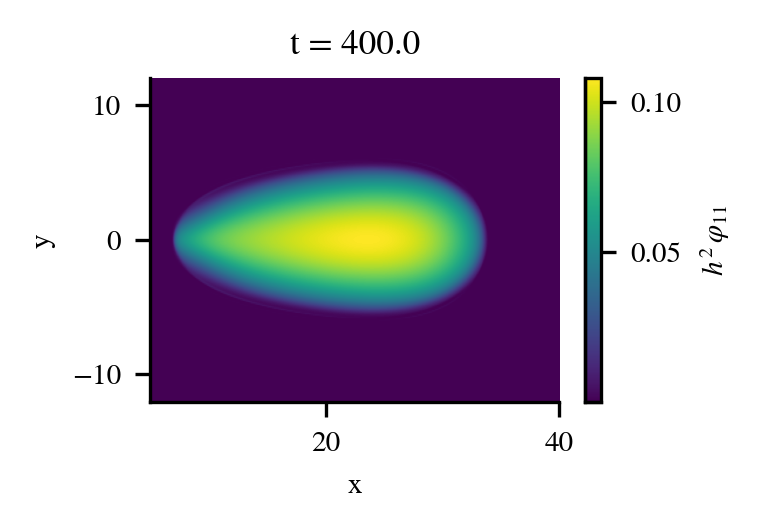

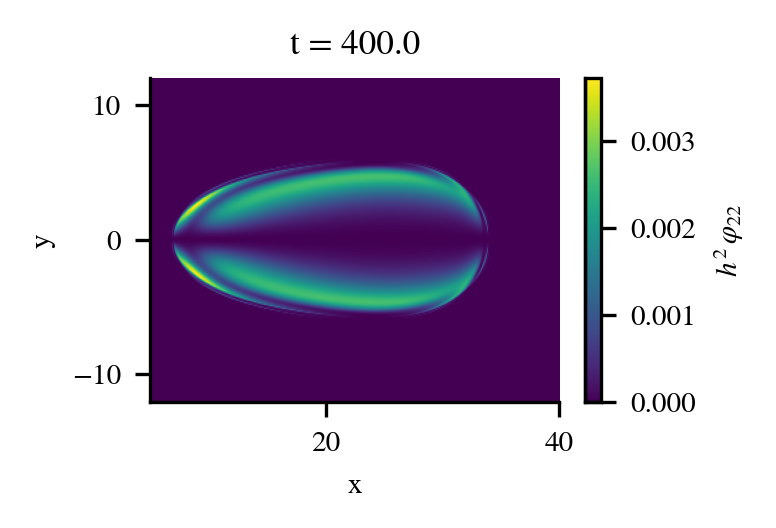

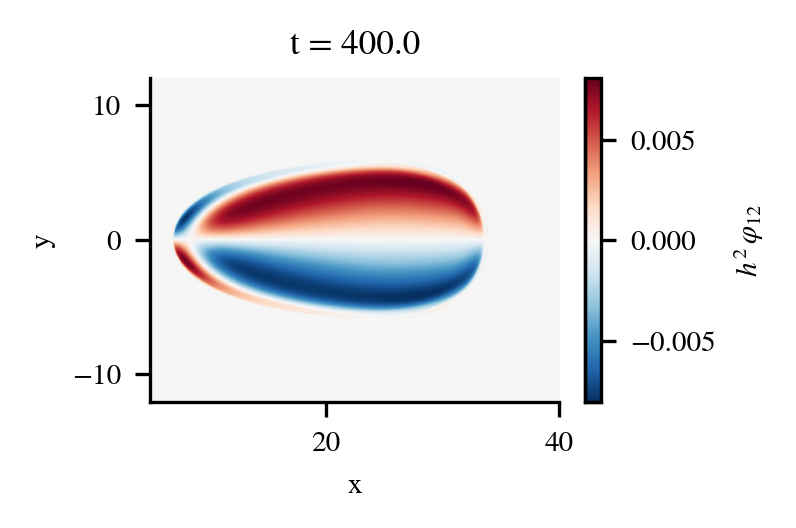

In [20]:
ds = xr.open_dataset("../data/outputs/2D_simple/dθₛ=0.nc")
ds = ds.sel(t=400)
ds = ds.roll(x=len(ds.x) // 2 - int(ds.sel(y=0).h.argmax("x")), roll_coords=False)

with plt.rc_context({"font.size": 7}):
    fig, ax = plt.subplots(figsize=(2.2, 1.4))
    ax.set_aspect("equal", "datalim")
    da = ds.ux  # .in
    da.rename(r"U").plot.imshow(
        interpolation="hamming", cmap="cividis", vmin=0.1, vmax=0.3, ax=ax
    )
    # set colorbar label
    ax.set_xlim(5, 40)
    sns.despine()
    savefig("fig07a")

with plt.rc_context({"font.size": 7}):
    fig, ax = plt.subplots(figsize=(2.2, 1.4))
    ax.set_aspect("equal", "datalim")
    da = ds.uy  # .in
    da.rename(r"V").plot.imshow(interpolation="hamming", ax=ax)
    ax.set_xlim(5, 40)
    sns.despine()
    savefig("fig07b")

with plt.rc_context({"font.size": 7}):
    fig, ax = plt.subplots(figsize=(2.2, 1.4))
    ax.set_aspect("equal", "datalim")
    da = ds["h"] ** 2 * ds["ϕxx"]
    da.rename(r"$h^2\,\varphi_{11}$").plot.imshow(interpolation="hamming", ax=ax)
    ax.set_xlim(5, 40)
    sns.despine()
    savefig("fig07c")

with plt.rc_context({"font.size": 7}):
    fig, ax = plt.subplots(figsize=(2.2, 1.4))
    ax.set_aspect("equal", "datalim")
    da = ds["h"] ** 2 * ds["ϕyy"]
    da.rename(r"$h^2\,\varphi_{22}$").plot.imshow(interpolation="hamming", ax=ax)
    ax.set_xlim(5, 40)
    sns.despine()
    savefig("fig07d")

with plt.rc_context({"font.size": 7}):
    fig, ax = plt.subplots(figsize=(2.2, 1.4))
    ax.set_aspect("equal", "datalim")
    da = ds["h"] ** 2 * ds["ϕxy"]
    da.rename(r"$h^2\,\varphi_{12}$").plot.imshow(interpolation="hamming", ax=ax)
    ax.set_xlim(5, 40)
    sns.despine()
    savefig("fig07e")

\begin{tabular}{lrrrr}
 & L & l & S & $h_{max}$ \\
dθₛ &  &  &  &  \\
0 & 27.200000 & 12.100000 & 261.640000 & 1.627094 \\
5 & 23.500000 & 12.900000 & 245.440000 & 1.807359 \\
9 & 19.500000 & 15.500000 & 238.340000 & 1.944052 \\
\end{tabular}



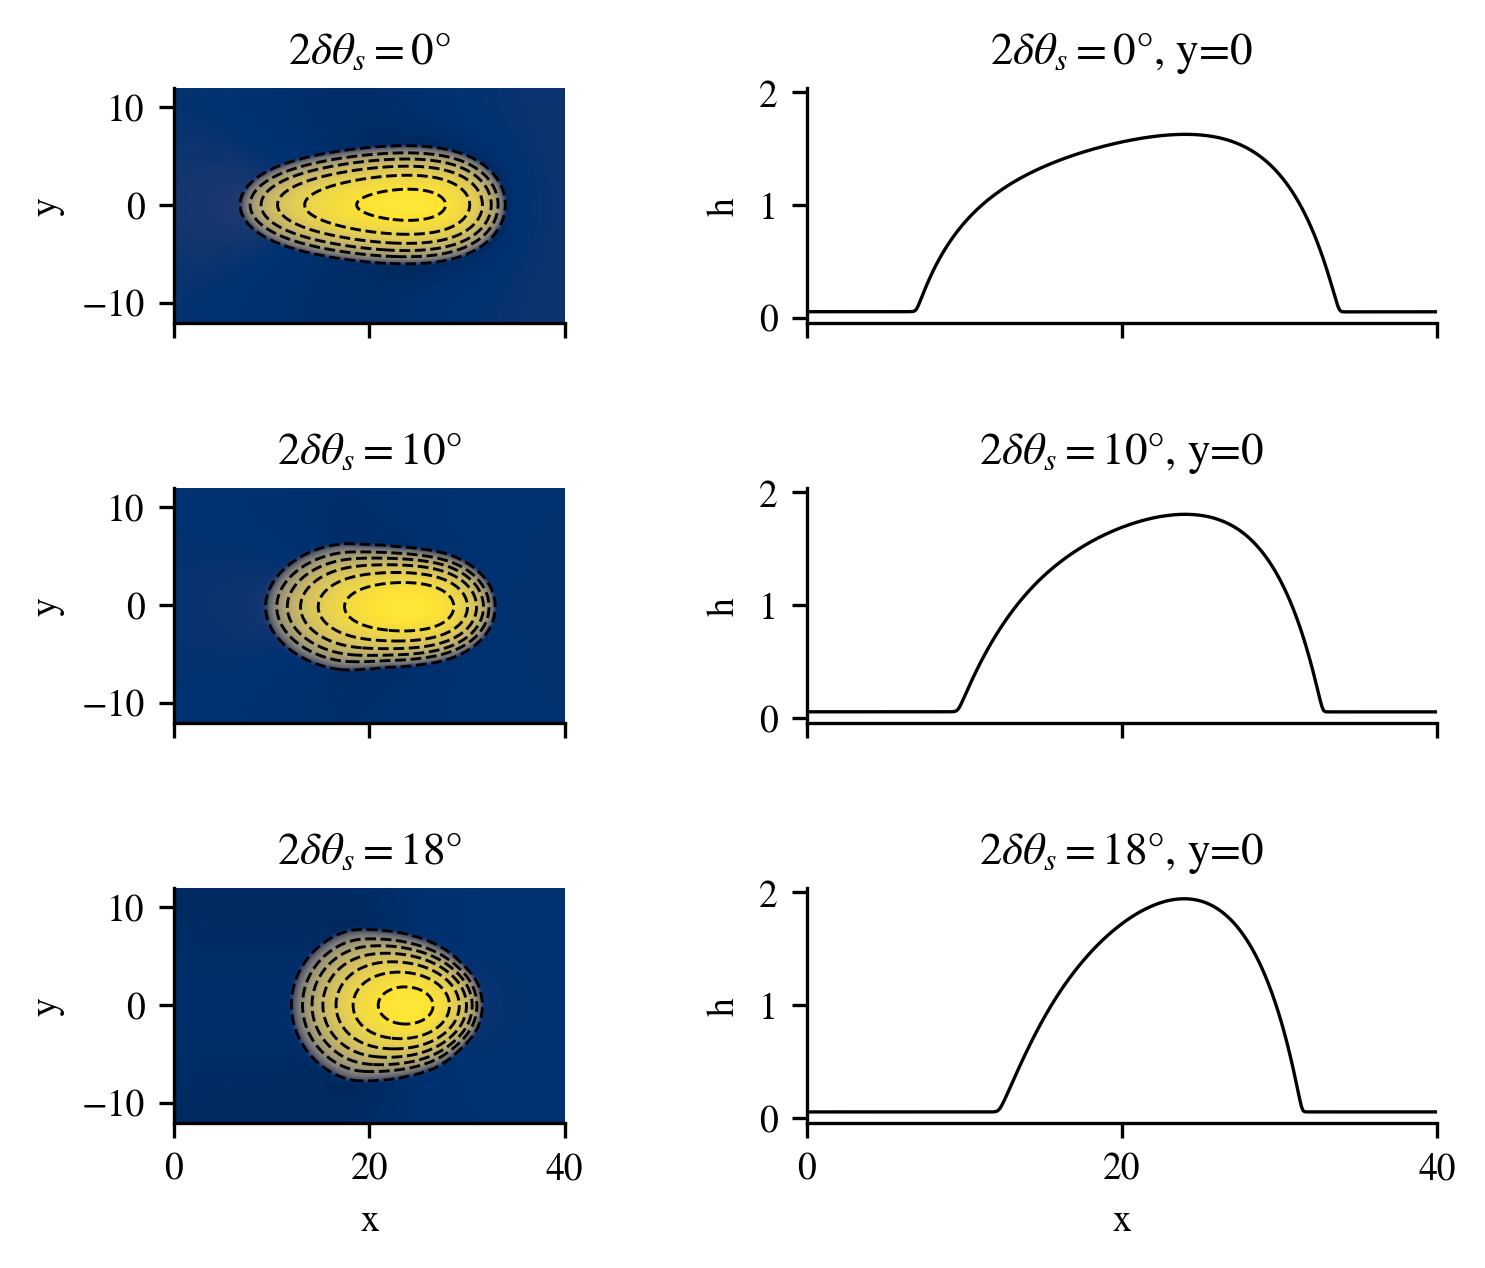

In [11]:
# fig 06
import pandas as pd


fig, axs = plt.subplots(3, 2, figsize=(5.3, 4.3), sharex=True, sharey="col")

res = []
for i, ((ax_main, ax_side), dθₛ) in enumerate(zip(axs, [0, 5, 9]), start=1):
    da = xr.open_dataset(f"../data/outputs/2D_simple/dθₛ={dθₛ}.nc").h.sel(t=350)
    # center with hmax
    da = da.roll(x=len(da.x) // 2 - int(da.sel(y=0).argmax("x")), roll_coords=False)
    δx = da.x[1] - da.x[0]
    in_drop = da > ds.attrs["hₛ"] * 1.1
    L = float(in_drop.sum("x").max() * δx)
    l = float(in_drop.sum("y").max() * δx)
    S = float(in_drop.sum() * δx**2)
    hmax = float(da.max())
    res.append([dθₛ, L, l, S, hmax])

    da.plot.imshow(
        cmap="cividis",
        interpolation="antialiased",
        add_colorbar=False,
        norm=plt.matplotlib.colors.PowerNorm(0.3),
        ax=ax_main,
    )

    cs = da.plot.contour(
        levels=np.linspace(5.5e-2, 2.1, 8),
        colors="black",
        linewidths=0.7,
        linestyles="--",
        ax=ax_main,
    )
    ax_main.set_xlim(0, 40)
    ax_main.set_aspect("equal")
    ax_main.set_title(rf"$2\delta\theta_s={2*dθₛ}°$")

    da.isel(y=len(da.y) // 2).plot(ax=ax_side, color="black", linewidth=0.8)
    ax_side.set_title(rf"$2\delta\theta_s={2*dθₛ}°$, y={0}")
    sns.despine()
df = (
    pd.DataFrame(res, columns=["dθₛ", "L", "l", "S", r"$h_{max}$"])
    .set_index("dθₛ")
    .sort_index()
)


fig.tight_layout()
[ax.set_xlabel("") for ax in axs[:-1, :].flat]
savefig("fig10")
print(df.style.to_latex())

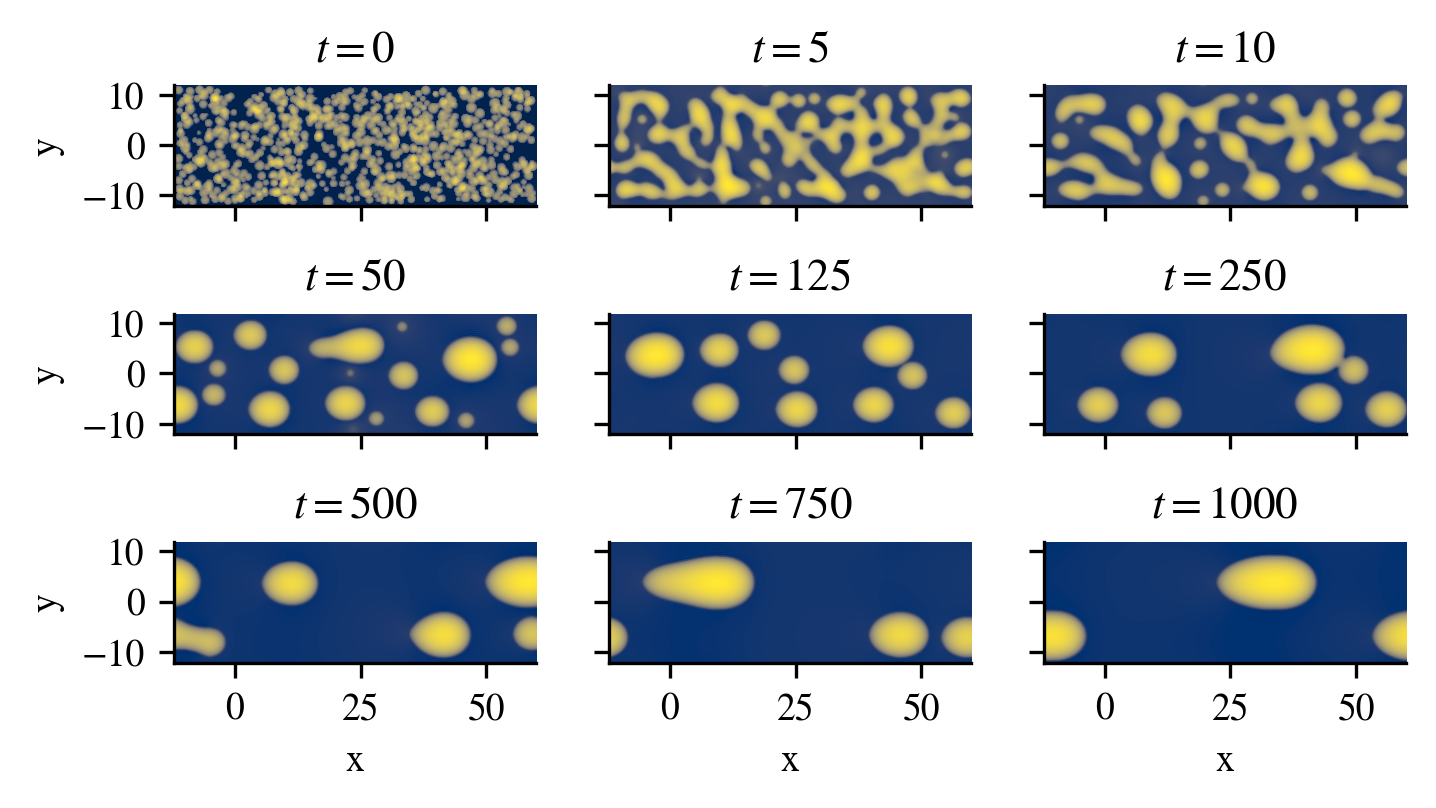

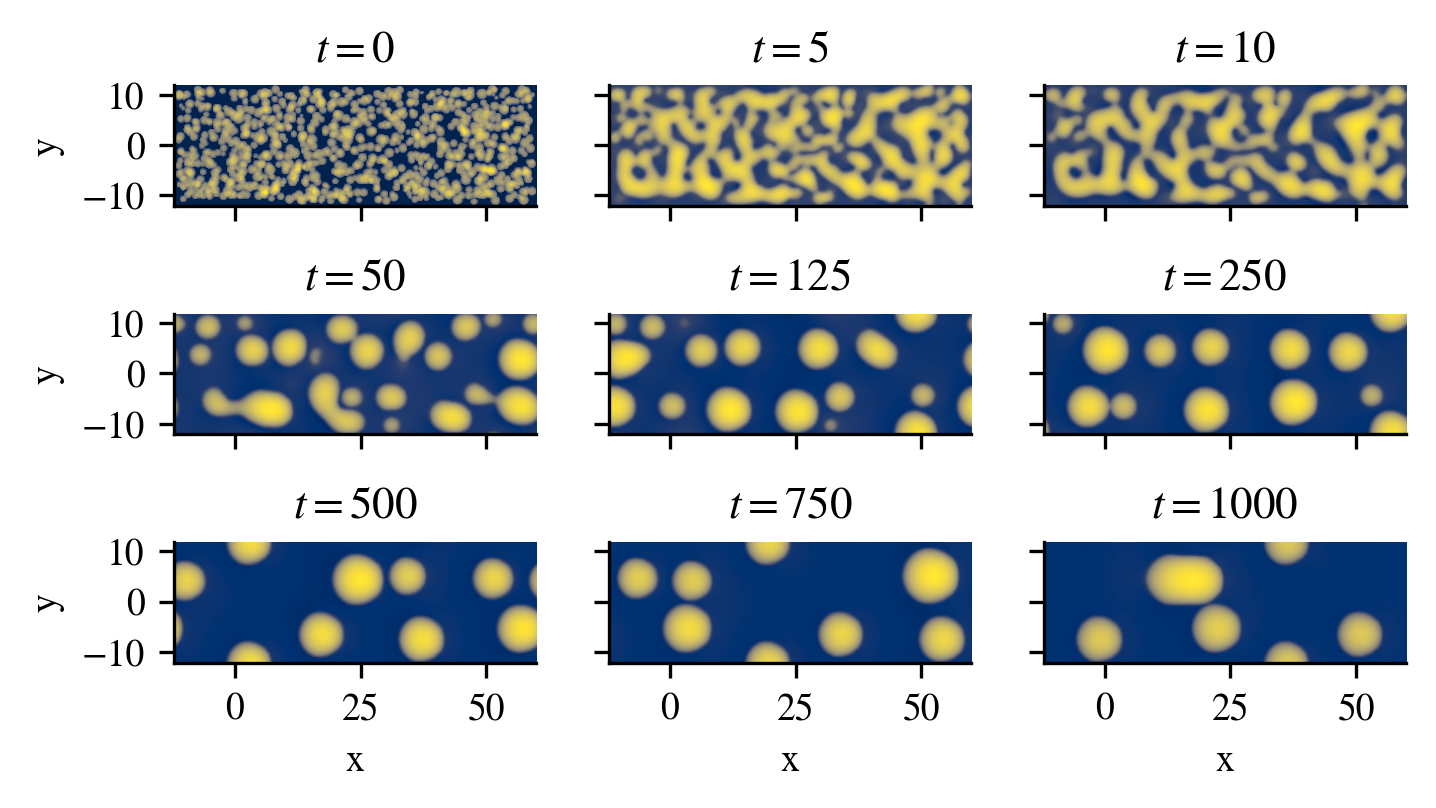

In [12]:
# fig 09+

for j, dθₛ in enumerate([0, 7]):
    fig, axs = plt.subplots(3, 3, figsize=(5.3, 2.8), sharex=True, sharey=True)
    ts = [0, 5, 10, 50, 125, 250, 500, 750, 1000]
    if not Path(f"../data/outputs/2D_multi_drop/dθₛ={dθₛ}.nc.done").exists():
        continue
    ds = xr.open_dataset(f"../data/outputs/2D_multi_drop/dθₛ={dθₛ}.nc").h
    for i, (ax, t) in enumerate(zip(axs.flat, ts), start=1):
        da = ds.sel(t=t)

        da.plot.imshow(
            cmap="cividis",
            interpolation="antialiased",
            add_colorbar=False,
            norm=plt.matplotlib.colors.PowerNorm(0.3),
            ax=ax,
        )
        ax.set_title(rf"$t={t:d}$")
        ax.set_aspect("equal")
        sns.despine()
    [ax.set_xlabel("") for ax in axs[:-1, :].flat]
    [ax.set_ylabel("") for ax in axs[:, 1:].flat]
    savefig(f"fig{11+j}")

In [13]:
from typing import Dict
from xarray import Dataset
from pathlib import Path
import xarray as xr
import seaborn as sns
from scipy.optimize import fmin
import pandas as pd


def find_max(da, x0=0, disp=False):
    return fmin(lambda x: -da.interp(x=x, method="quadratic"), x0=x0, disp=disp)


datasets: Dict[str, Dataset] = {}
for ds in sorted(
    Path("../data/outputs/2D_param_L/").glob("*.nc"),
    key=lambda x: float(x.stem.split("_")[0].replace("L=", "")),
):
    if not ds.with_name(f"{ds.name}.done").exists():
        continue
    ds = xr.open_dataset(ds)
    datasets[(round(ds.attrs["mass"], 1), int(ds.attrs["dθₛ"]))] = ds

res = []
for mass, dθₛ in sorted(datasets.keys()):
    ds = datasets[(mass, dθₛ)]
    hmax_pos = ds.x[ds.h.isel(y=len(ds.y) // 2).argmax("x")]
    ptp = ds.x.max() - ds.x.min()
    dx = ds.x[1] - ds.x[0]
    area = (hmax_pos.diff("t") < -ptp / 2).cumsum().rename("area")
    largest_area = area.to_dataframe().area.value_counts().index[0]
    hmax_pos = hmax_pos.where(area == largest_area, drop=True)
    c = float(hmax_pos.polyfit("t", deg=1).polyfit_coefficients.sel(degree=1).squeeze())
    res.append({"mass": mass, "dθₛ": dθₛ, "c": c})
vel_df = pd.DataFrame(res)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


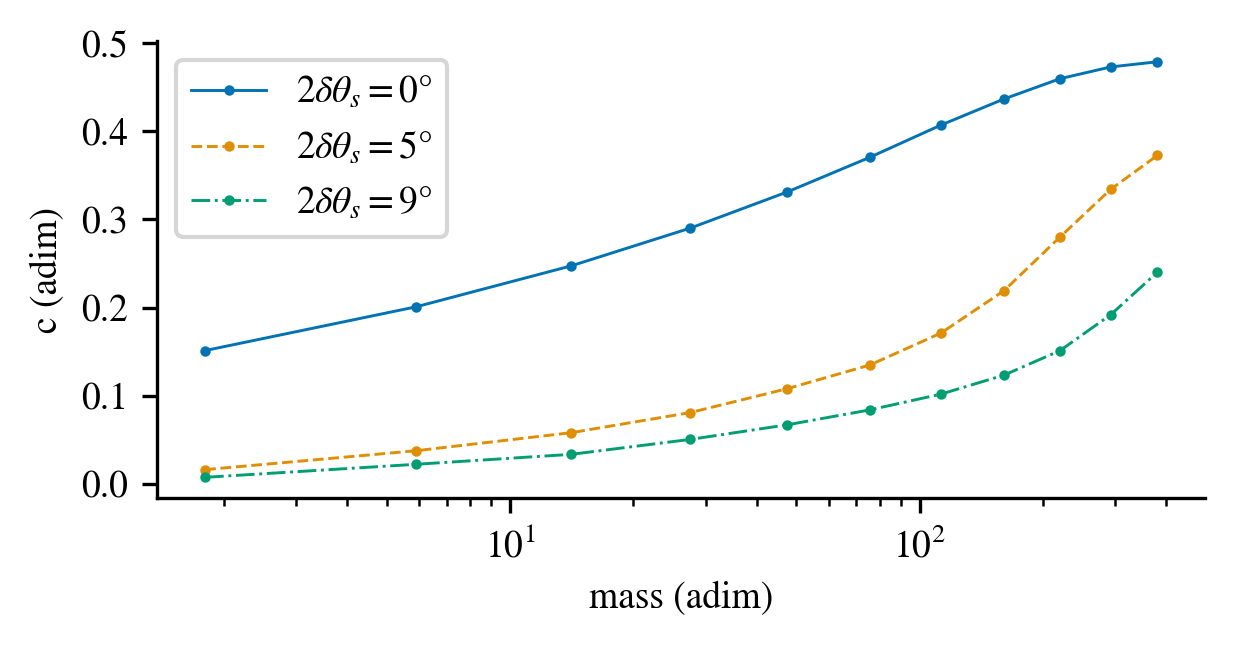

In [14]:
from matplotlib.rcsetup import cycler

fig, ax = plt.subplots(figsize=(4, 2), constrained_layout=True)
sns.set_palette("colorblind")
ls_cycle = cycler(linestyle=["-", "--", "-.", ":"])
color_cycler = cycler(color=sns.color_palette("colorblind", n_colors=len(ls_cycle)))
ax.set_prop_cycle(ls_cycle + color_cycler)
for dθₛ, sdf in vel_df.groupby("dθₛ"):
    sdf.plot(
        x="mass",
        y="c",
        label=f"$2\\delta\\theta_s={dθₛ}°$",
        ax=ax,
        marker=".",
        linewidth=0.7,
        markersize=3,
    )
ax.set_xlabel("mass (adim)")
ax.set_ylabel("c (adim)")
ax.set_xscale("log")
sns.despine()

savefig("fig13")

In [15]:
import pandas as pd

L = 24 * 3
df = pd.read_csv("../data/outputs/bench_timestep.csv")
df["dx"] = (df["n"] - 1) / L

In [16]:
from scipy.optimize import curve_fit


# dt = a dx^2
def theorical_fit(dx, a, n):
    dt = a * dx**n
    return dt

In [17]:
(a, n), _ = curve_fit(theorical_fit, df.dx, df.dt, p0=(1, 1), maxfev=10000)
th_dx = np.linspace(df.dx.min(), df.dx.max(), 100)
th_dt = theorical_fit(th_dx, a, n)

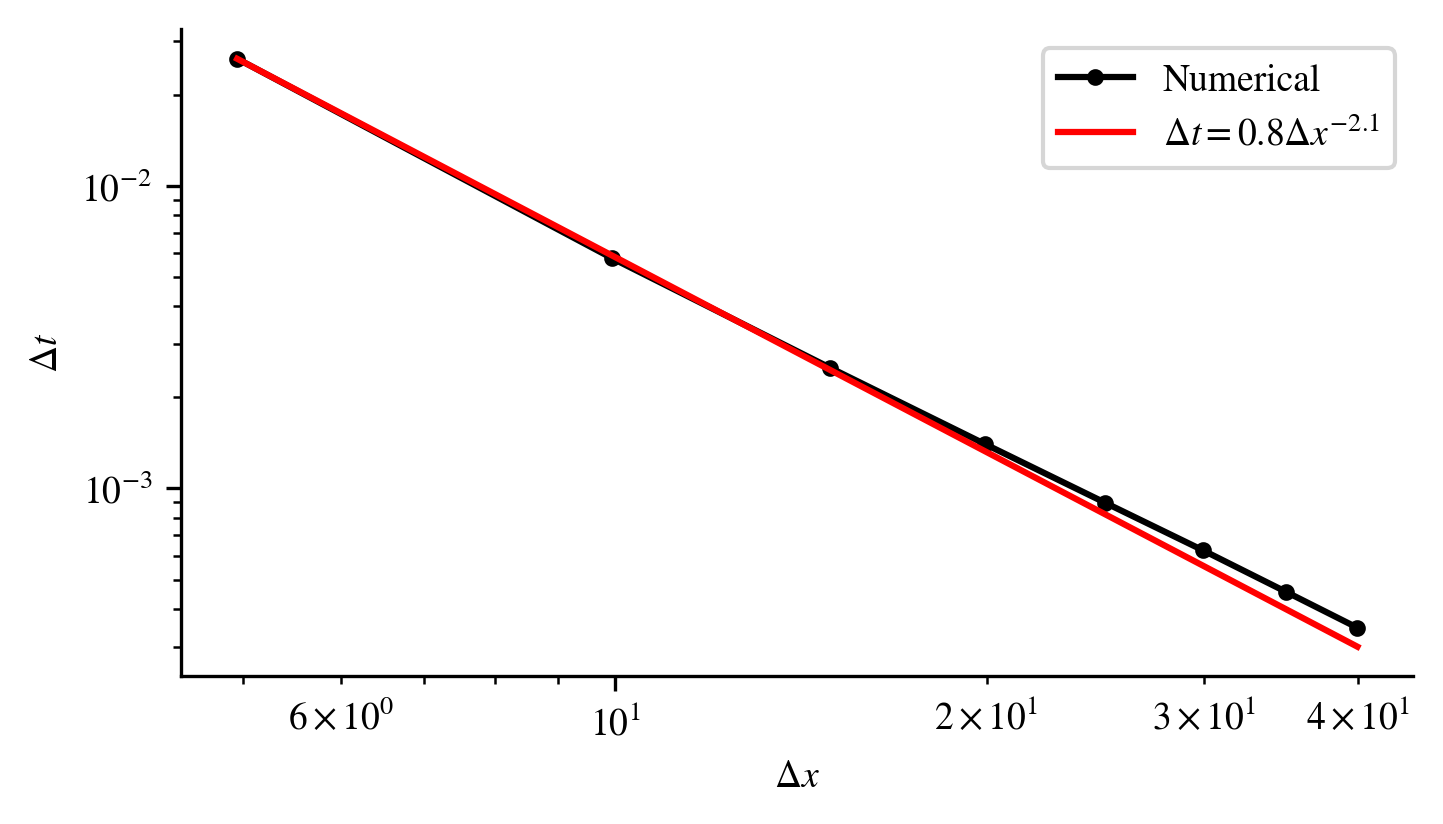

In [18]:
fig, ax = plt.subplots(figsize=(5.3, 2.8))

ax.plot("dx", "dt", data=df, marker=".", color="k", label="Numerical")
ax.plot(
    th_dx,
    th_dt,
    color="r",
    alpha=1,
    label=r"$\Delta t = %.1f \Delta x^{%.1f}$" % (a, n),
)
ax.set_xlabel(r"$\Delta x$")
ax.set_ylabel(r"$\Delta t$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
sns.despine()